In [1]:
from load_data import load_data
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
from vispy.color import ColorArray
from PIL import Image

In [2]:
%config Completer.use_jedi = False

In [3]:
def print_image(img):
    plt.imshow(img, interpolation='nearest')
    plt.show()

In [4]:
def save_image(img , saveto):
    cv2.imwrite(saveto, img) 
    print("The image is saved under ", saveto)
    

In [5]:
#data = load_data(os.getcwd()+"/data/demo.p")
data = load_data(os.getcwd()+"/data/demo.p")
velodyne =  data['velodyne']
objects = data['objects']
print("The first 3 dimensions represent x,y,z and the last one represents the reflectance intensity  between 0 - 1")
print("Shape is "+ str(velodyne.shape))
print("We know that the maximum range is 120 m" )
num_of_points = velodyne.shape[0]

The first 3 dimensions represent x,y,z and the last one represents the reflectance intensity  between 0 - 1
Shape is (125897, 4)
We know that the maximum range is 120 m


## Task 1 Bird's Eye of View

In [6]:
# ==============================================================================
#                                                                   SCALE_TO_255
# ==============================================================================
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)

In [7]:
# ==============================================================================
#                                                          BIRDS_EYE_POINT_CLOUD
# ==============================================================================
def BEV_from_cloud(points, saveto , side_range = 0,fwd_range= 0,res = 0 ,min_height= 0, max_height=0):
    """ Creates an 2D birds eye view representation of the point Lidar 3D cloud data.
        You can optionally save the image to specified filename.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z and the intensity value/reflectance
                    shape is n x 4
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (float) desired resolution in metres to use
                    Each output pixel will represent an square region res x res
                    in size.
        min_height:  (float)(default=-2.73)
                    Used to truncate height values to this minumum height
                    relative to the sensor (in metres).
                    The default is set to -2.73, which is 1 metre below a flat
                    road surface given the configuration in the kitti dataset.
        max_height: (float)(default=1.27)
                    Used to truncate height values to this maximum height
                    relative to the sensor (in metres).
                    The default is set to 1.27, which is 3m above a flat road
                    surface given the configuration in the kitti dataset.
        saveto:     (str or None)(default=None)
                    Filename to save the image as.
                    If None, then it just displays the image.
    """
    max_velodyne = np.amax(points, 0)
    max_x = max_velodyne [0]
    max_y = max_velodyne [1]
    max_z = max_velodyne [2]
    min_velodyne = np.amin(points, 0)
    min_x = min_velodyne [0]
    min_y = min_velodyne [1]
    min_z = min_velodyne [2]


    #Assign to the corresponding variables
    side_range =(min_y ,max_y )
    fwd_range = (min_x , max_x)
    max_height = max_z
    min_height = min_z
    
    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    r_lidar = points[:, 3]  # Reflectance
    
    #side_range = range_of_vec(points[:,1])
    #fwd_range = range_of_vec(points[:,0])
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_lidar/res).astype(np.int32) # x axis is -y in LIDAR
    y_img = (x_lidar/res).astype(np.int32)  # y axis is -x in LIDAR
                                                     # will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img -= int(np.floor(side_range[0]/res))
    y_img -= int(np.floor(fwd_range[0]/res))



    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    #pixel_values  = scale_to_255(z_lidar, min=min_height, max=max_height)
    pixel_values = scale_to_255(r_lidar,min=0.0,max=1.0)
    
    # FILL PIXEL VALUES IN IMAGE ARRAY
    x_max = int((side_range[1] - side_range[0])/res)
    y_max = int((fwd_range[1] - fwd_range[0])/res)
    img = np.zeros([y_max, x_max], dtype=np.uint8)
    img[-y_img, x_img] = pixel_values # -y because images start from top left


    
    # SAVE THE IMAGE
    if saveto == "no":
        img = Image.fromarray(img)
        return img
    else :
        if saveto :
            save_image(img, saveto)
        else:
            cv2.imshow('image', img)
            cv2.waitKey(10000)
            print("You can view the BEV from the 3D Lidar points")
    

In [8]:
#Convert the 3D Lidar points to BEV view
img = BEV_from_cloud(velodyne , res = 0.2 , saveto = "task1.jpg")


The image is saved under  task1.jpg


## Task 2.1 3D Lidar Point Cloud Projection to 2D image

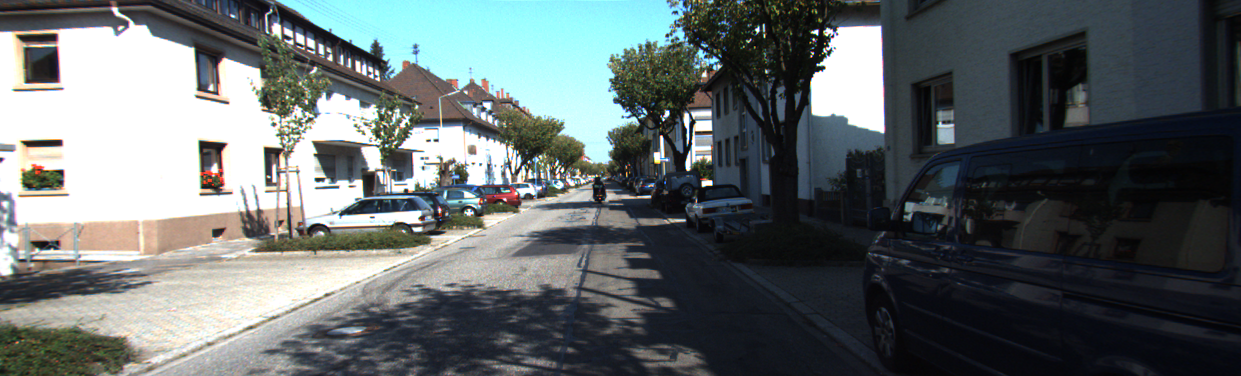

In [9]:
data = load_data('data/data.p') # Change to data.p for your final submission 
img = data["image_2"]
R1 = data["T_cam2_velo"] # this consitutes our extrinsic parameters matrix
R2 = data["P_rect_20"] #this constitues our intrinsic parameters matrix
# Both R1 and R2 constitute the camera calibration of our scene that helps project the 3D lidar points to a 2D image plane
im = Image.fromarray(np.uint8(img), "RGB")
display(im)

In [10]:
def project_point_cloud( p , img):

    ind = p[:,0]>=0 # keep only the points that have an x>=0
    points = p[ind] #keep the points only with the corresponding indeces
    label_clip = data['sem_label'][ind] # get the semantic labels for each point of the cloud


    # Homonegenous
    P = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
    # Multiply different parameter matrices to project 3D points on the 2D camera 2 image

    #Extrinsic & intrinsic
    print("The shape of the homogenous lidar points is ", P.shape)
    print("The shape of the intrinsic matrix is ", R2.shape)
    print("The shape of the extrinsic matrix is ", R1.shape)

    P_2 = np.empty(points.shape)

    for ind,point in enumerate(P):
        # Projection
        P_2[ind,:] = np.dot(np.dot(R2,R1),point)  # project for each point of the the Lidar = (1x3)
        # Normalization
        P_2[ind,:] = P_2[ind,:]/P_2[ind,-1] #normalize with the last element, to end up with 1 in the last dimension -> homogenous coordinates

    print("The final 2D projected data have shape ", P_2.shape)

    P_2 = P_2.astype(int)



    #Get image and display it
    img = np.uint8(img) #convert uint32 to uint8 with RGB channels
    print( "our image is ", img.dtype)
    '''cv2.imshow('image' , img)
    cv2.waitKey(10000) '''

    # Filter out ones not inside the perspective
    ind_x = np.logical_and(P_2[:,1] < img.shape[0], P_2[:,1] >= 0)
    ind_y = np.logical_and(P_2[:,0] < img.shape[1], P_2[:,0] >= 0)
    ind_z = P_2[:,-1]>=0
    ind = np.logical_and(ind_x,ind_y)
    ind = np.logical_and(ind,ind_z)

    #Convert the index to integer
    P_clip = P_2[ind].astype(int)
    label_clip = label_clip[ind]

    # Color for each pixel position
    color = np.empty([P_clip.shape[0],3])
    for ind,label in enumerate(label_clip):
        color[ind,:] = data['color_map'][label[0]]
        color[ind,:] = [color[ind,-1],color[ind,1],color[ind,0]]
    #color = ColorArray(color,clip=True)

    projected_cloud_pixels = P_clip

    for i,point in enumerate(projected_cloud_pixels):
        u = point[1] # corresponds to y
        v = point[0] # corresponds to x 
        img = cv2.circle(img, (v,u), radius=1, color=color[i,:] , thickness=1) # make pixels more visible
        #img[point[1],point[0],:] = color[i,:]
    return img , projected_cloud_pixels

our image is  int32
The shape of the homogenous lidar points is  (59055, 4)
The shape of the intrinsic matrix is  (3, 4)
The shape of the extrinsic matrix is  (4, 4)
The final 2D projected data have shape  (59055, 3)
our image is  uint8
The image is saved under  task2_1.jpg


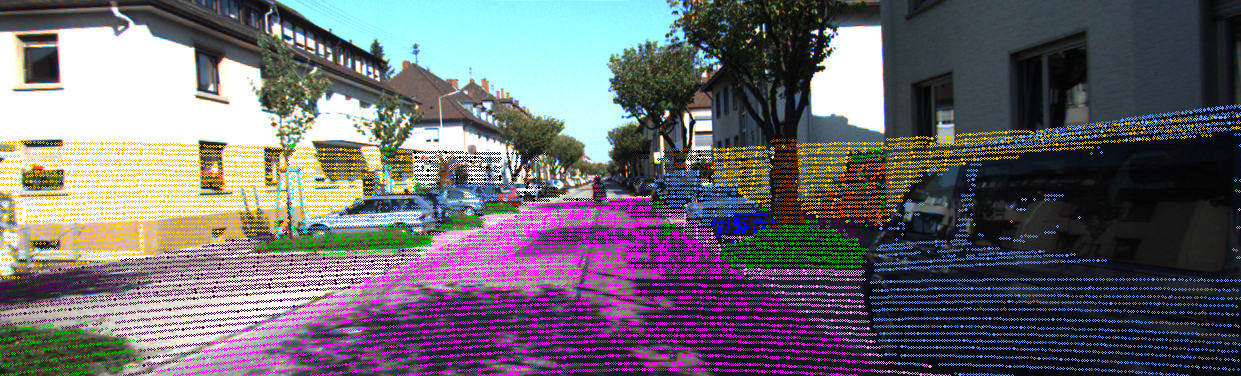

In [11]:
 velodyne = data['velodyne']
points = velodyne [:,:-1] # keep only the 3 dimensions of velodyne data 
#forward direction only => Filter out the points of the backward direction
img = data['image_2']
print( "our image is ", img.dtype)
#Save to image
saveto = "task2_1.jpg"
image , projection = project_point_cloud(points, img)
save_image(image,saveto)
img2 = Image.fromarray(np.uint8(image), "RGB")
img2


## Task 2.2 3D bbox on 2D image

In [12]:
data = load_data('data/demo.p') # Change to data.p for your final submission 
img = data["image_2"]
R1 = data["T_cam2_velo"]
R2 = data["P_rect_20"]
im = Image.fromarray(np.uint8(img), "RGB")

objects = data['objects']
corners = np.empty([len(objects),8,3])
i = 0
for individual in objects:
    '''3 dimensions 3D object dimensions: height, width, length (in meters)
    3 location 3D object location x,y,z in Cam 0 coordinates (in meters) describing the center
    of the bottom face of the bounding box'''
    # Height, Width, Length 
    dimension = np.array(individual[8:11])
    bbox_height = dimension[0]
    bbox_width = dimension[1]
    bbox_length =  dimension[2]
    # Right, Down, Front (X,Y,Z)
    location = np.array(individual[11:14])
    bbox_x = location[0]
    bbox_y = location[1]
    bbox_z = location[2]
    rotation_y = individual[14]
    corner = np.zeros([8,3])
    corner[0,:] = location + np.array([bbox_width/2,-bbox_height, bbox_length/2])
    corner[1,:] = corner[0,:] + np.array([-bbox_width ,0 , 0])
    corner[2,:] = corner[1,:] + np.array([0 ,0,-bbox_length])
    corner[3,:] = corner[2,:] + np.array([bbox_width, 0, 0])
    corner[4,:] = corner[0,:] + np.array([0, bbox_height ,0])
    corner[5,:] = corner[4,:] + np.array([-bbox_width,0, 0])
    corner[6,:] = corner[5,:] + np.array([0,0,-bbox_length])
    corner[7,:] = corner[6,:] + np.array([bbox_width,0,0])
    # Rotate along the y-axis
    #R = np.array([[1,0,0],[0,np.cos(rotation_y),np.sin(rotation_y)],[0,-np.sin(rotation_y),np.cos(rotation_y)]])
    #ind = 0
    #for point in corner:
    #    corner[ind,:] = np.dot(R,point)
    #    ind += 1
    corners[i,:,:] = corner
    i += 1
#R = data['P_rect_00']
T = np.eye(4)
T[0,3] = 0.06
for bbox in corners:
    for ind,pt in enumerate(bbox):
        pos = np.dot(np.dot(R2,T),np.concatenate((pt,[1])))
        pos /= pos[-1]
        pos = pos.astype(int)
        bbox[ind]=pos
   
corners = corners.astype(int,copy=False)


The image is saved under  task2_2.jpg


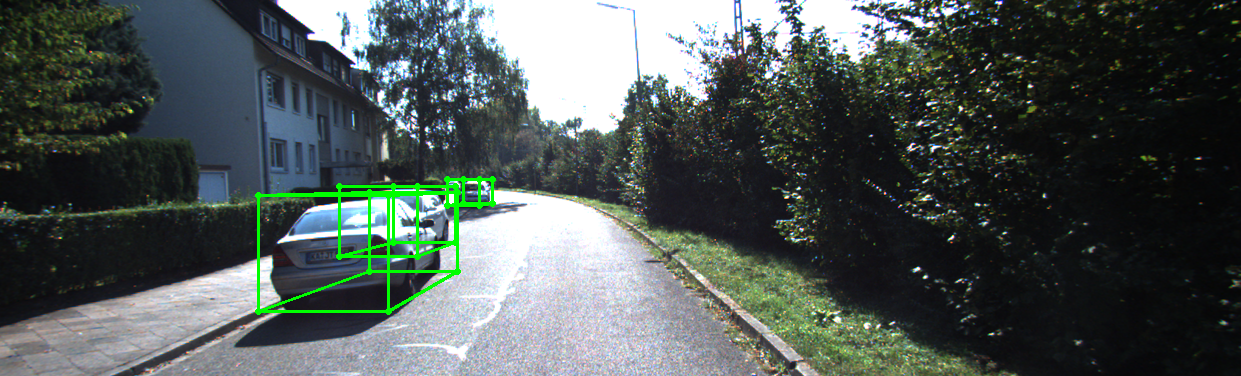

In [13]:
thickness = 2
color = (0,255,0)
radius = 2
for box in corners:
    for corner in box:
        img = cv2.circle(img,tuple(corner[:-1]),radius,color,thickness)
    # (0,1),(0,3),(0,4),(1,2),(1,5),(2,3),(2,6),(3,7),(4,5),(4,7),(5,6),(6,7)

    img = cv2.line(img,tuple(box[0,:-1].astype(int)),tuple(box[1,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[0,:-1].astype(int)),tuple(box[3,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[0,:-1].astype(int)),tuple(box[4,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[1,:-1].astype(int)),tuple(box[2,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[1,:-1].astype(int)),tuple(box[5,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[2,:-1].astype(int)),tuple(box[3,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[2,:-1].astype(int)),tuple(box[6,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[3,:-1].astype(int)),tuple(box[7,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[4,:-1].astype(int)),tuple(box[5,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[4,:-1].astype(int)),tuple(box[7,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[5,:-1].astype(int)),tuple(box[6,:-1].astype(int)),color,thickness)
    img = cv2.line(img,tuple(box[6,:-1].astype(int)),tuple(box[7,:-1].astype(int)),color,thickness)
save_image (img , "task2_2.jpg")
im = Image.fromarray(np.uint8(img), "RGB")
display(im)


### Visualize the 3D point cloud with bbox on camera 3D coordinate system

In [14]:

# Deep Learning for Autonomous Driving
# Material for Problem 2 of Project 1
# For further questions contact Ozan Unal, ozan.unal@vision.ee.ethz.ch

import vispy
from vispy.scene import visuals, SceneCanvas
import numpy as np
import os
from load_data import load_data
from vispy.color import ColorArray

class Visualizer():
    def __init__(self):
        self.canvas = SceneCanvas(keys='interactive', show=True)
        self.grid = self.canvas.central_widget.add_grid()
        self.view = vispy.scene.widgets.ViewBox(border_color='white',
                        parent=self.canvas.scene)
        self.grid.add_widget(self.view, 0, 0)

        # Point Cloud Visualizer
        self.sem_vis = visuals.Markers()
        self.view.camera = vispy.scene.cameras.TurntableCamera(up='z', azimuth=90)
        self.view.add(self.sem_vis)
        visuals.XYZAxis(parent=self.view.scene)
        
        # Object Detection Visualizer
        self.obj_vis = visuals.Line()
        self.view.add(self.obj_vis)
        self.connect = np.asarray([[0,1],[0,3],[0,4],
                                   [2,1],[2,3],[2,6],
                                   [5,1],[5,4],[5,6],
                                   [7,3],[7,4],[7,6]])
        self.data = load_data('data/data.p') # Change to data.p for your final submission 
    def update(self, points):
        '''
        :param points: point cloud data
                        shape (N, 3)          
        Task 2: Change this function such that each point
        is colored depending on its semantic label
        '''
        R1 = data["T_cam0_velo"]
        for i,point in enumerate(points):
            pos = np.dot(R1,np.concatenate((point,[1]))) #convert to cam0 coordinate system
            pos /= pos[-1] #normalize point
            points[i,:] = pos[:-1] #change the points with the new points(different coordinate system)
        color = np.empty([points.shape[0],3])
        for ind,label in enumerate(self.data['sem_label']):
            color[ind,:] = self.data['color_map'][label[0]]
            # BGR -> RGB
            color[ind,:] = [color[ind,-1],color[ind,1],color[ind,0]]

        color = ColorArray(color,clip=True)
        self.sem_vis.set_data(points,edge_color=color, size=3)
    
    def update_boxes(self, corners):
        '''
        :param corners: corners of the bounding boxes
                        shape (N, 8, 3) for N boxes
        (8, 3) array of vertices for the 3D box in
        following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
        If you plan to use a different order, you can
        change self.connect accordinly.
        '''
        for i in range(corners.shape[0]):
            connect = np.concatenate((connect, self.connect+8*i), axis=0) \
                      if i>0 else self.connect
        self.obj_vis.set_data(corners.reshape(-1,3),
                              connect=connect,
                              width=2,
                              color=[0,1,0,1])

if __name__ == '__main__':
    data = load_data('data/data.p') # Change to data.p for your final submission 
    visualizer = Visualizer()
    visualizer.update(data['velodyne'][:,:3])
    '''
    Task 2: Compute all bounding box corners from given
    annotations. You can visualize the bounding boxes using
    visualizer.update_boxes(corners)
    '''
    # Finding the bbox
    # TODO: Clip the point to the edge
    # (N,8,3) dimension array of corners
    corners = np.empty([len(data['objects']),8,3])
    i = 0
    for individual in data['objects']:
        # Height, Width, Length 
        dimension = np.array(individual[8:11])
        bbox_height = dimension[0]
        bbox_width = dimension[1]
        bbox_length =  dimension[2]
        # # Right, Down, Front (X,Y,Z)
        location = np.array(individual[11:14])
        bbox_x = location[0]
        bbox_y = location[1]
        bbox_z = location[2]
        rotation_y = individual[14]
        corner = np.zeros([8,3])

        corner[0,:] = location + np.array([bbox_length/2,-bbox_height,bbox_width/2])
        corner[1,:] = corner[0,:] + np.array([-bbox_length,0,0])
        corner[2,:] = corner[1,:] + np.array([0,0,-bbox_width])
        corner[3,:] = corner[2,:] + np.array([bbox_length,0,0])
        for k in range(4):
            corner[k+4,:] = corner[k,:] + np.array([0,bbox_height,0])
        # Rotate along the y-axis
        T = np.array([[location[0]],[location[1]-bbox_height/2],[location[2]]])
        R = np.array([[np.cos(rotation_y),0,np.sin(rotation_y)],[0,1,0],[-np.sin(rotation_y),0,np.cos(rotation_y)]])
        R1 = np.block([[R,np.dot(-R,T)+T],[0,0,0,1]])
        j = 0
        for point in corner:
            pos= np.dot(R1,np.concatenate((point,[1])))
            pos /= pos[-1]
            corner[j,:] = pos[:-1]
            j += 1
        corners[i,:,:] = corner
        i += 1
    visualizer.update_boxes(corners)
    vispy.app.run()


In [15]:
# If it doesn't work just run the script
!python "3dvis.py" 

## Task 3 Laser ID

In [16]:
from load_data import load_data
from data_utils import line_color
import os
from task2 import project_lidar_data_on_image
from matplotlib import pyplot as plt
import numpy as np
import cv2
from vispy.color import ColorArray
from PIL import Image

def convert_rad_to_deg(value):
    return value * 57.2958

def range_of(array):
    print(array.shape)
    max_ = np.amax(array)
    min_ = np.amin(array)
    return tuple([min_,max_])

def project_laser_id(points , projected_points , img , save):
    ''' this method receives the lidar point cloud, 
        as well as the corresponding 2D projected points on the image '''

    lines_of_search = 64 
    # According to the VELODYNE HDL datashet HDL-64E
    min_FOV = -24.9
    max_FOV = 2.0
    FOV = max_FOV - min_FOV
    # so this gives us a range for our theta angle and we have to divide each 3D point to which part of the FOV it belongs to
    FOV_interval = FOV/lines_of_search
    angle = 2.0
    theta = []
    # Divide the angles in different bins. Seperate bins with interval of approximately 2 degrees (according to calculation)
    for i in range(0 ,lines_of_search):
        theta.append(angle)
        angle -= FOV_interval
    theta_vector =np.array(theta)

    #Find which points belong to which FOV lines, depending on their atan
    # we only need x (the forward direction) and z (the upward direction)
    x = points[: , 0]
    z = points[: ,2]
    tan_values = np.divide (z , x)
    theta_of_points = np.arctan(tan_values) # get the angles in radians for all points
    theta_deg_of_points = convert_rad_to_deg(theta_of_points) # get the agnels in degrees for all points
    print(range_of(theta_deg_of_points))

    #Filter out indexes that are outside this range 
    index = np.logical_and(max_FOV>=theta_deg_of_points , theta_deg_of_points >=min_FOV)
    theta_deg_of_points = theta_deg_of_points[index] # keep only the respective angles, for the respective ponits in the FOV
    projected_points  = projected_points [index] #get also all the projected points that are within are FOV 



    # get the angles as range with each array element holding the starting angle and end_angle for each bin
    list_theta_range= []
    for i in range(1, theta_vector.shape[0]):
        list_theta_range.append([theta_vector[i], theta_vector[i-1]])
    theta_vector_ranges = np.array(list_theta_range)


    #Find the indeces corresponding to the various bins
    line_ids = []
    for i , theta_range in enumerate(theta_vector_ranges):
        max_theta = theta_range[0]
        min_theta = theta_range[1]
        index_bin = np.logical_and(theta_deg_of_points<=min_theta , theta_deg_of_points>=max_theta) #find index of points that match this bin
        line_ids.append(index_bin)
        
    #replace points with this index with appropriate line ID
    id = 1
    for index in line_ids:
        projected_cloud_pixels = projected_points[index]
        for point in enumerate(projected_cloud_pixels):
            pixels = point[1]
            u = pixels[1] # corresponds to y
            v = pixels[0] # corresponds to x 
            color_HSV  = np.uint8([[[line_color(id) , 255 , 255]]])
            color_RGB =  cv2.cvtColor(color_HSV, cv2.COLOR_HSV2RGB)
            color_of_line = (int(color_RGB[0,0,0]) , int(color_RGB[0,0,1]), int(color_RGB[0,0,2]))
            img = cv2.circle(img, (v,u), radius=1, color= color_of_line, thickness=1) # color is determined according to laser id
            #img[point[1],point[0],:] = color[i,:]
        id += 1
    


    #Check if you need to save the image
    if(save == 1):
        cv2.imwrite("task3.jpg" ,cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) #the image is expressed as BGR , so convert when saving
    #PIL method - Show pic with lines of search
    image= Image.fromarray(img, "RGB")
    return image

In [17]:
print("So let's start the task")
data_path = os.path.join("./data", "demo.p") # change to data.p for submission
data = load_data(data_path)
velodyne =  data['velodyne']
objects = data['objects']
#Get image and display it
image= data['image_2']
print( "our image is ", image.dtype)
image = np.uint8(image) #convert uint32 to uint8 with RGB channels
print( "our image is ", image.dtype , " with shape " , image.shape)
image_original = np.copy(image)
lidar_points , projected_points , output_image  = project_lidar_data_on_image(data , objects , image , bbox = 'no')
output2_image = project_laser_id(lidar_points ,projected_points , image_original , save = 1)

So let's start the task
our image is  int32
our image is  uint8  with shape  (376, 1241, 3)
The shape of the homogenous lidar points is  (64495, 4)
The shape of the intrinsic matrix is  (3, 4)
The shape of the extrinsic matrix is  (4, 4)
The final 2D projected data have shape  (64495, 3)
For a random point of the cloud we have  [586 151   1] with u =  151  and v =  586
Remember that the camera coordinates are different => Camera: x: right, y: down, z: forward . Think of how the velodyne would look from the camera coordinates perspective
Remember that for our image we can only have pixel locations within (u,v) range of the image => (376, 1241)
The label segmentation matrix has the numeric segmentation labels , e.g for point 1 [70]
With no bbox rectangles draw on image
(20342,)
(-15.357237, 4.9831953)


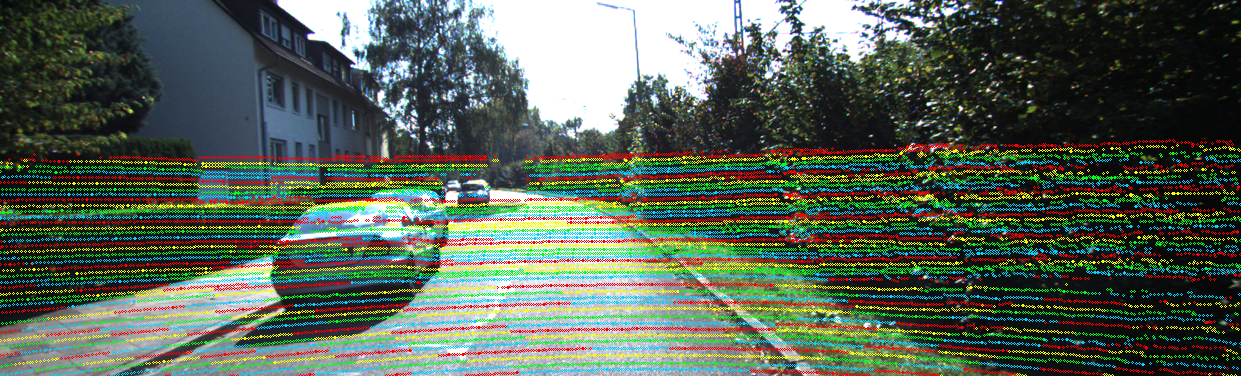

In [18]:
output2_image

## Task 4 Remove Motion Blur

In [19]:
from dateutil import parser
def import_date_from_file(file):
    lines = []
    with open( file , 'r') as file:
        data = file.read()
    date_strings= data.split('\n')
    date_strings = date_strings[:-1]
    for date_string in date_strings:
        date_string.split(' ')[1]
        datetime_obj = parser.parse(date_string)
        lines.append(datetime_obj)
    
    return np.array(lines)

### Load all data file

In [20]:
#Velodyne HDL64 runs at 10Hz -> 10 rotations per second (10 times ->360 deg)
# 36000 deg per sec 
#linear motion at 50 km/h causes a gap of 1.38 m between start & end of scan
#rotation motion at a rotation motion at 25/s creates a gap of 2.19 m 
#at a distance of 50 m.
# Use Camera, Lidar & IMU/GPS location data and make use of frame timestamps
# Remember that the velodyne goes clockwise -> towards the negative direction

from os import listdir
from os.path import isfile, join
import numpy as np
from data_utils import load_from_bin
from data_utils import calib_velo2cam
from data_utils import depth_color
from data_utils import load_oxts_velocity
from data_utils import load_oxts_angular_rate
from data_utils import calib_cam2cam
from data_utils import compute_timestamps
from data_utils import print_projection_plt

### Path to individual dta file

In [21]:
file_end = "data/problem_4/velodyne_points/timestamps_end.txt"
file_start = "data/problem_4/velodyne_points/timestamps_start.txt"
file_trigger = "data/problem_4/velodyne_points/timestamps.txt"
file_image_taken = "data/problem_4/image_02/timestamps.txt"
velodyne_points = "data/problem_4/velodyne_points"
oxts_file = "data/problem_4/oxts/timestamps.txt"
calib_velo2cam_filepath = "data/problem_4/calib_velo_to_cam.txt"
calib_cam2cam_filepath = "data/problem_4/calib_cam_to_cam.txt"
calib_imu2velo_filepath = "data/problem_4/calib_imu_to_velo.txt"
example = 37    

### Load all time stamps

#### Velodyne

In [22]:
# Timestamp of Velodyne
t_velo_start = compute_timestamps(file_start,example)
t_velo_end = compute_timestamps(file_end,example)

In [23]:
# Get velodyne point clouds for all recordings/rotations
def load_vel_pts(mypath, example):
    onlyvelodynefiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    point_cloud = 0 ; #initialize
    velo_file = 0
    for file in onlyvelodynefiles:
        if (file == str(example).zfill(10)+'.bin'):
            file_path = join(mypath, file)
            velo_file = file_path
            points = load_from_bin(file_path)
    return points
mypath = "data/problem_4/velodyne_points/data/"
points = load_vel_pts(mypath, example)
        

#### Camera

data/problem_4/image_02/data\0000000037.png


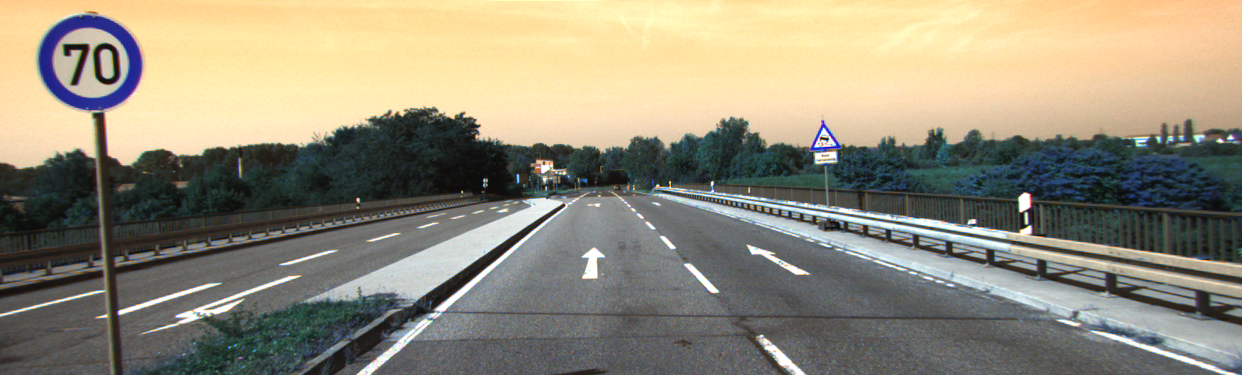

In [24]:
#get all corresponding frames
image_path = 'data/problem_4/image_02/data'
onlyimagefiles = [f for f in listdir(image_path) if isfile(join(image_path,f))]
img = 0 #initialize
for file in onlyimagefiles:
    if (file == str(example).zfill(10)+'.png'):
            file_path = join(image_path, file)
            print(file_path)
            img = cv2.imread(file_path)
            im = Image.fromarray(np.uint8(img), "RGB")
            display(im)

#### IMU

In [25]:
# Timestamp of IMU sensor activation
oxts_filepath = "data/problem_4/oxts/timestamps.txt"
t_imu = compute_timestamps(oxts_filepath,example)
imu_filepath = "data/problem_4/oxts/data/{0:010d}.txt".format(example)
lin_velocity = load_oxts_velocity(imu_filepath)
ang_velocity = load_oxts_angular_rate(imu_filepath)
dt = t_velo_end - t_velo_start

### Distance calculation of 3D points from vehicle(0,0,0)

In [26]:
def find_distance_of_3D_points(points):
    '''This takes as input argument the 3D point cloud np.array
        and returns an nparray corresponding to the distance for each point'''
    distances  = np.sum(points**2,axis = 1)
    return distances

### Project colored velodyne data, based on distance

In [27]:
def project_colored_points(calib_velo2cam_filepath, calib_cam2cam_filepath, points, img):
    #get real world distance for each projected point on the image
    distances = find_distance_of_3D_points(points)
    distances /= 75
    
    #perform Rigid transformation
    ind = points[:,0]>=0 # keep only the points that have an x>=0 
    points = points[ind] #keep the points only with the corresponding indeces
    distances = distances[ind]
    # Homonegenous
    points = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
    R , T = calib_velo2cam(calib_velo2cam_filepath) #get the R and T matrices to project on camera coordinates
    print("The shape of the rotation matrix is ", R.shape)
    print("The shape of the translation matrix is ", T.shape)
    R1 = np.block([[R , T],[0,0,0,1]])
    R2 = calib_cam2cam(calib_cam2cam_filepath,'02')
    
    points_uv = np.empty([points.shape[0],2])
    for ind,point in enumerate(points):
        # Projection
        projection = np.dot(np.dot(R2,R1),point)
        # Normalization
        points_uv[ind,:] = projection[:-1]/projection[-1] 
    points = points_uv.astype(int)
    

    # Filter out ones not inside the perspective
    ind_x = np.logical_and(points[:,1] < img.shape[0], points[:,1] >= 0)
    ind_y = np.logical_and(points[:,0] < img.shape[1], points[:,0] >= 0)
    ind_z = points[:,-1]>=0
    ind = np.logical_and(ind_x,ind_y)
    ind = np.logical_and(ind,ind_z)
    

    #Convert the index to integer
    points = points[ind].astype(int)
    distances = distances[ind]


    # Color for each pixel position
    color = depth_color(distances)
    
    img = print_projection_plt(points.transpose(),color,img)
    return img
    
    

The shape of the rotation matrix is  (3, 3)
The shape of the translation matrix is  (3, 1)


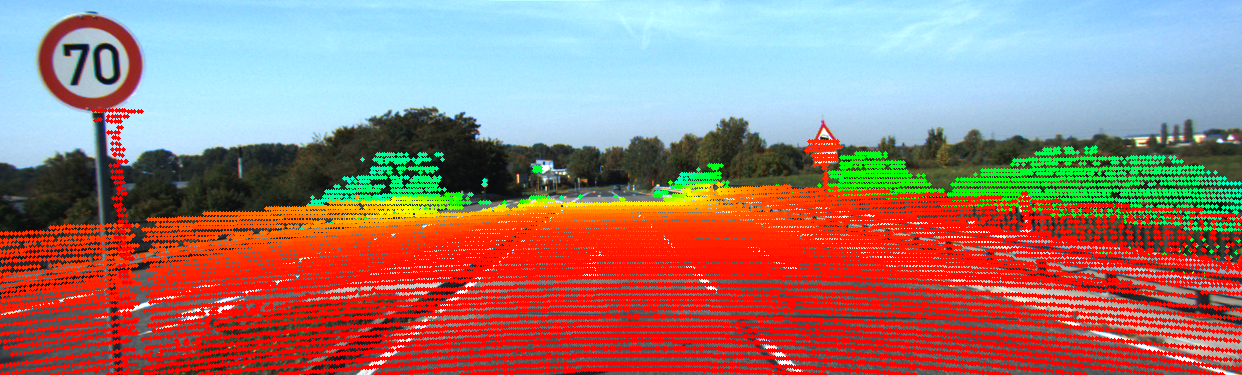

In [28]:
# Determine which actual point_cloud and test_frame corresponds to the 37th frame   
points = load_vel_pts(mypath, example)
test_image= project_colored_points(calib_velo2cam_filepath, calib_cam2cam_filepath, points, img)
img2 = Image.fromarray(np.uint8(test_image), "RGB")
img2

### Remove Motion Blur

In [29]:
def transform(lin_velocity,ang_velocity,calib_imu2velo_filepath):
    ry = ang_velocity[1] * -dt
    R = np.array([[np.cos(ry),0,np.sin(ry)],[0,1,0],[-np.sin(ry),0,np.cos(ry)]]) 
    T = np.array([0,0,0]).reshape(-1,1)
    T = lin_velocity.reshape(-1,1)* -dt/10
    R1 = np.block([[R,T],[0,0,0,1]])
    R1 = R1 
    R1 = R1 / R1[-1,-1]

    # imu2velo
    S = []
    with open(calib_imu2velo_filepath) as f:
        i = 0
        for line in f:
            if i == 0:
                i += 1
                continue
            (key, val) = line.split(": ")
            S.append(val.split("\n")[0])
    R = np.array([float(i) for i in S[0].split(" ")]).reshape(3,3)
    T = np.array([float(i) for i in S[1].split(" ")]).reshape(-1,1)
    R_end = np.block([[R,T],[0,0,0,1]])
    # vel2imu -> imu rotate -> imut2vel
    return np.dot(R_end,np.dot(R1,np.linalg.inv(R_end)))


In [30]:
def project_colored_points_adjusted(calib_velo2cam_filepath, calib_cam2cam_filepath, points, img):
    #get real world distance for each projected point on the image
    distances = find_distance_of_3D_points(points)
    distances /= 75
    
    #perform Rigid transformation

    ind = points[:,0]>=0 # keep only the points that have an x>=0 
    points = points[ind] #keep the points only with the corresponding indeces
    distances = distances[ind]
    # Homonegenous
    points = np.concatenate([points,np.ones([points.shape[0],1])],axis=1)
    R , T = calib_velo2cam(calib_velo2cam_filepath) #get the R and T matrices to project on camera coordinates
    print("The shape of the rotation matrix is ", R.shape)
    print("The shape of the translation matrix is ", T.shape)
    R1 = np.block([[R , T],[0,0,0,1]])
    R2 = calib_cam2cam(calib_cam2cam_filepath,'02')
    
    points_uv = np.empty([points.shape[0],2])
    # Transform due to the movement
    R = transform(lin_velocity,ang_velocity,calib_imu2velo_filepath)
    for ind,point in enumerate(points):
        # Projection
        projection = np.dot(np.dot(R2,R1),np.dot(R,point))
        # Normalization
        points_uv[ind,:] = projection[:-1]/projection[-1] 
 
    points = points_uv.astype(int)
    
    

    # Filter out ones not inside the perspective
    ind_x = np.logical_and(points[:,1] < img.shape[0], points[:,1] >= 0)
    ind_y = np.logical_and(points[:,0] < img.shape[1], points[:,0] >= 0)
    ind_z = points[:,-1]>=0
    ind = np.logical_and(ind_x,ind_y)
    ind = np.logical_and(ind,ind_z)
    

    #Convert the index to integer
    points = points[ind].astype(int)
    distances = distances[ind]


    # Color for each pixel position
    color = depth_color(distances)
    
    img = print_projection_plt(points.transpose(),color,img)
    return img
    

The shape of the rotation matrix is  (3, 3)
The shape of the translation matrix is  (3, 1)


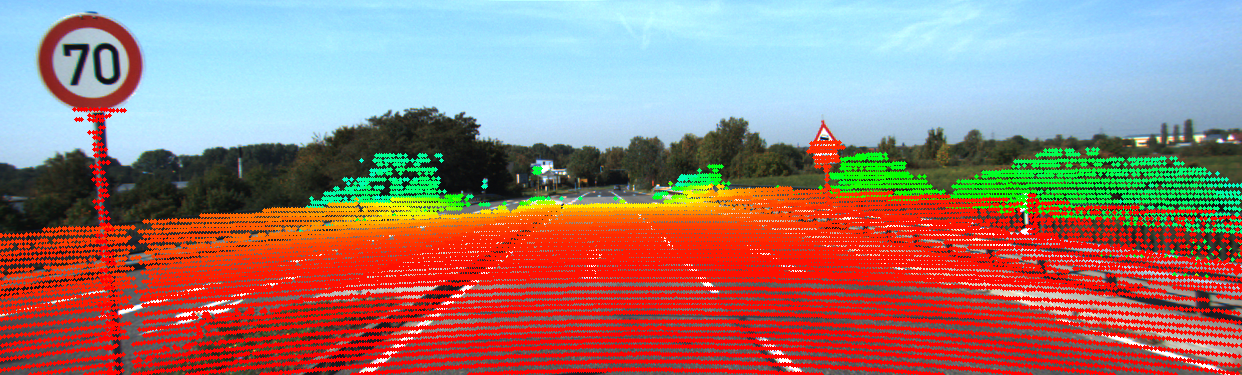

In [31]:
# Determine which actual point_cloud and test_frame corresponds to the 37th frame   
points = load_vel_pts(mypath, example)
test_image= project_colored_points_adjusted(calib_velo2cam_filepath, calib_cam2cam_filepath, points, img)
img3 = Image.fromarray(np.uint8(test_image), "RGB")
img3